# **Better Edges**

- Stephen Welch
- UNCC Computer Vision

**Required Reading/Viewing:**

1. Placeholder 

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:
````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

![](graphics/spacer_small.png)

### Problems with our implementation of Robert's Cross from last time

1. **Noisy** - Robert's Cross is quite susceptible to noise.
2. **Anisotropic** - doesn't respond as strongly to slanted edges. 
3. **Slow** as we've implemented it here.
4. **No Direction** as we've implemented Robert's Cross here, we only learn about the **magnitude** of our esimate of the image intensity derivative, not its **direction.** 

Hopefully you've taken some time to think through some possible fixes to these problems. Let's have a look at them one at a time.

## **1. Noisy**

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load image
im = imread('data/medium_2/ball/ball_3.jpg')

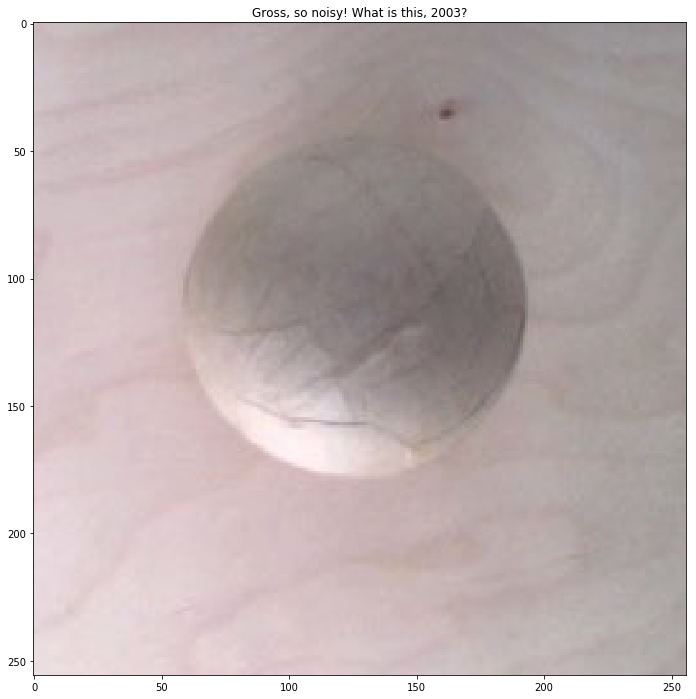

In [3]:
#Let's have a look
fig = figure(0, (12,12))
imshow(im)
title('Gross, so noisy! What is this, 2003?');

** This is a particularly noisy image from our dataset - it was captured under relatively low light conditions with the webcam of my 2008 macbook.**

![](videos/noisy_image_rotating_3.gif)

- Let's have a look at the result of our implementation of Robert's Cross from last time on this image. 
- This is brings us to some important points about how we'll be using python in the couse.

## A little bit about python + the jupyter notebook

- There's a couple of methods from our last notebook that we would like to use here. 
- We could copy + paste these methods into this notebook, but a better appraoch is to create a python module in a seperate .py file that holds commonly used code. 
- You may have noticed the "util" directory in this repo:

In [4]:
ls

README.md                       data/
[1] The Original Problem.ipynb  graphics/
[2] Edges.ipynb                 papers/
[3] Better Edges.ipynb          util/
challenge/                      videos/


It contains a serveral python modules that contain the various methods we'll develop in the module:

In [5]:
ls util/*

util/filters.py  util/image.py

util/__pycache__:
filters.cpython-36.pyc  image.cpython-36.pyc


- Let's go have a look at one of these .py files in a text editor. 
- We can import specific methods from these .py files like this: 

In [6]:
from util.image import convert_to_grayscale

While we're at it, let's look a few nice notebook features. We can see the docstring of the methods we're using right in the notebook by adding a question mark to the end of method or class names:

In [7]:
convert_to_grayscale?

Another nice feature: Press **Shift+Tab** with your cursor inside a methods parenthesis to see it's arguments. 

![](graphics/spacer_small.png)

![](videos/shift_tab.gif)

![](graphics/spacer_small.png)

And finally, you can access search all commands using the command pallate:
- **(cmnd + shift + p)** on mac
- **(ctrl + shift + p)** on linux/windows

And to view all keyboard shortucts press **esc** then **h.**

![](videos/jupyter_shortcuts.gif)

### **One more thing about importing python modules**

- Modules are compiled on import. 
- If we poke around our util director after import, we see that each python file is compiled into it's own .pyc in a python automatically generated directory called \__pycache__

In [8]:
ls util*

__pycache__/ filters.py   image.py


In [9]:
ls util/__pycache__/

filters.cpython-36.pyc  image.cpython-36.pyc


- The important thing to note here is that if you make a change to a .py file, the results of this change will not actually show up **until you reimport the module**, recompiling the .py into .pyc.
- Generally, I'll just run "Restart and Run All" from the Kernel dropdown menu when I make a module change. 
- **Quick Demo:**

In [10]:
gray = convert_to_grayscale(im/255.)

![](graphics/spacer_small.png)

![](graphics/spacer_small.png)

### **Ok, enough fun with jupyter - let's process our noisy image.**

In [11]:
gray = convert_to_grayscale(im)

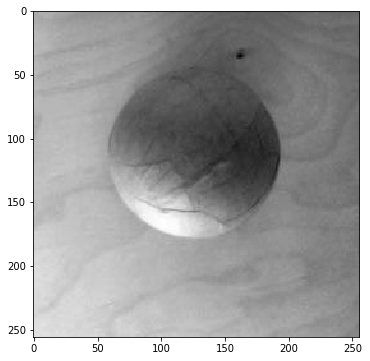

In [12]:
fig = figure(0, (6,6))
imshow(gray, cmap = 'gray')

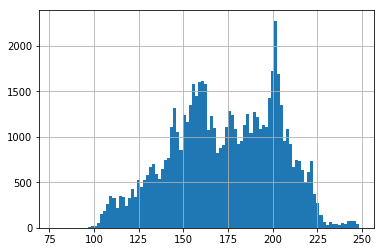

In [13]:
hist(gray.ravel(), 100);
grid(1)

In [14]:
from util.filters import roberts_cross

In [15]:
edges = roberts_cross(gray)

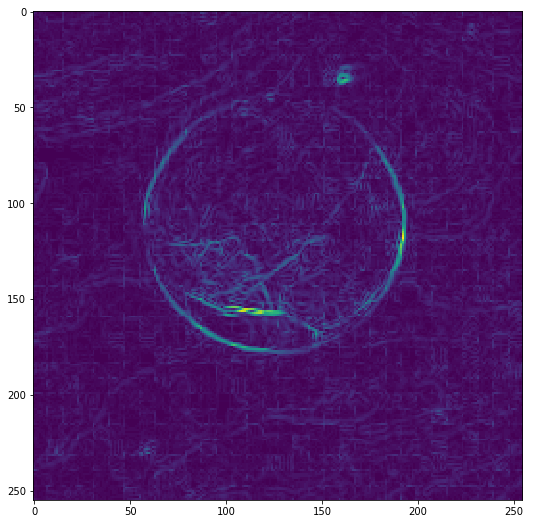

In [16]:
fig = figure(0, (9,9))
imshow(edges)

## Now, how can we remove some of the noise from our image?

- Any ideas?
- Are there properties of our noise that we can exploit to help us seperate it from our signal?

![](videos/noisy_image_rotating_1.gif)

## **Local Averages**

A very successful/popular appraoch to noise reduction is to replace the individual pixels in our images with some type of weighted average of their local neighborhoods.

![](graphics/local_averaging-01.png)

# **How would this operation change the appearance of our image?**

![](graphics/spacer_small.png)

- Let's find out!
- Now, before we code this up, let's generalize this process a little.
- A more general way to think about the average of our neighborhood is as the dot product of our image patch with a (3x3) matrix.

In [23]:
#Little trick to progress through slides within the notebook
from IPython.display import Image, display
from ipywidgets import interact

#Quick method to let me step through "slides"
def slide_show(slide_num):     
    display(Image('graphics/averaging_slides/' + str(slide_num).zfill(2) + '.png'))

In [25]:
interact(slide_show, slide_num = (1, 2));

A Jupyter Widget

- It turns out that taking the dot product of our image patch with a small matrix or kernel like this is incredibly common in computer vision.
- Doing this across a whole image is called filtering, convolution, or cross correlation, we'll get into the details later.
- Let's write a method to filter an image with an arbitray kernel/filter.

In [ ]:
def filter_2d(im, kernel):
    '''
    Filter an image by taking the dot product of each 
    image neighborhood with the kernel matrix.
    Args:
    im = (n x m) grayscale floating point image
    kernel = (o x p) matrix, smaller than im
    Returns: 
    (n-o+1 x m-p+1) filtered image
    '''
    
    kernel_height = kernel.shape[0]
    kernel_width = kernel.shape[1]
    
    filtered_image = np.zeros((im.shape[0]-kernel_height+1, 
                              im.shape[1]-kernel_width+1),
                              dtype = 'float64')
    
    for i in range(filtered_image.shape[0]):
        for j in range(filtered_image.shape[1]):
            image_patch = im[i:i+kernel_height, j:j+kernel_width]
            filtered_image[i, j] = np.sum(np.multiply(image_patch, kernel))
            
    return filtered_image